In [1]:

# %%
# -*- coding: utf-8 -*-
"""
Jared Baca
Class: CS 677
Date: July 24, 2023
Final Project

Created on Mon July 24 2023
@author: jbaca

The goal of this project is to evaluate the accuracy of several machine learning algorithms for 
classifying music files by genre.
Some preprocessing and analysis is done on the data including feature importance, a correlation matrix, 
and a scatterplot showing the relationship between the 2 most important features.

The dataset used is the GTZAN dataset, available at 
https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

"""
import os
import numpy as np
import pandas as pd

input_dir = r'Data/'
data = os.path.join(input_dir, 'features_30_sec.csv')

# =============== Open The CSV File ===============

try:
    df = pd.read_csv(data)

except Exception as e:
    print(e)
    print('failed to open csv file')



In [2]:
# =============== Feature List ===============

"""
Chroma STFT
RMS
Spectral Centroid
Spectral Bandwidth
Spectral Rolloff
Zero Crossing Rate
Harmony
Perceptr
Tempo
Mel-Frequency Cepstral Coefficients (MFCC)
"""

'\nChroma STFT\nRMS\nSpectral Centroid\nSpectral Bandwidth\nSpectral Rolloff\nZero Crossing Rate\nHarmony\nPerceptr\nTempo\nMel-Frequency Cepstral Coefficients (MFCC)\n'

In [3]:
# =============== Create Feature and Response Vectors ===============

#Using all features
X = df.iloc[:,2:-1]

#Drop features that are not part of the Librosa library. 
X = X.drop(['harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var'], axis=1)

#Using only Zero-Crossing, Spectral Centroid, Spectral Rolloff, tempo
# X = df[['spectral_centroid_mean', 'rolloff_mean','zero_crossing_rate_mean', 'tempo', 'harmony_mean']]

y = df['label']

<Axes: >

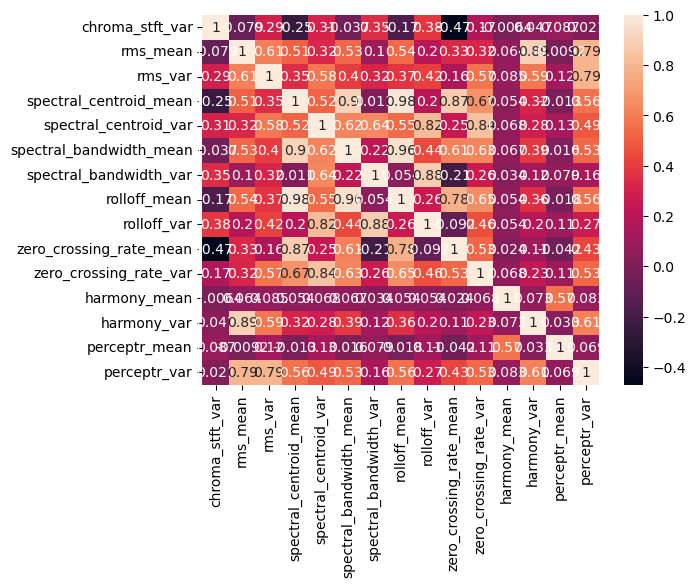

In [4]:
import seaborn as sns

# =============== Create Correlation Matrix Heatmap ===============

"""
The most correlated features proved to be Rolloff Mean and Spectral Centroid Mean, 
Rolloff Mean and Spectral Bandwidth Mean, and Spectral Centroid Mean and Spectral Bandwidth Mean
"""

# calculate the correlations
correlations = df.iloc[:,3:18].corr()

# plot the heatmap 
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True)


In [5]:
#Drop Highly Correlated Features

X = X.drop(['spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var'], axis=1)

In [6]:
# =============== Apply feature scaling ===============

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [7]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# =============== Create Testing and Training Sets ===============

"""
I tested with both scaled and unscaled data. Scaling the data improved the accuracy
for the KNN algorithm and did not affect the Random Forest or Decision Tree classifiers,
so I chose to use the scaled data.
"""


#Unscaled Data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 

#Scaled Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y) 


In [8]:
from random import randint, sample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


# =============== Evaluate Random Forest Classifier ===============

"""
Below we will evaluate the performance of several different algorithms, including the Random Forest Classifier.
Before creating the RF Classifier, I evaluated it to find the best hyperparameters.
"""

rf = RandomForestClassifier()

param_dist = {
    'n_estimators': sample(range(50,500),5),
    'max_depth': sample(range(1,20),5)
}

# Use random search to find best hyperparameters
rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=5
)

# Fit the random search object to data
rand_search.fit(X_train, y_train)

# Create variable for best model
best_rf = rand_search.best_estimator_

# Print hyperparameters
print('Best Hyperparameters:', rand_search.best_params_)


Best Hyperparameters: {'n_estimators': 314, 'max_depth': 14}


In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import VotingClassifier

# =============== Testing the accuracy of several models ===================

"""
The Random Forest Classifier proved to be the most accurate, with between 70-75% accuracy.
The K-Nearest Neighbors classifier was a close second.
"""

#Train Classifiers
knn = KNeighborsClassifier(n_neighbors=6)
nb = GaussianNB()
rf = best_rf #from random test above
dt = DecisionTreeClassifier()

voting_clf = VotingClassifier(
        estimators = [('knn', knn), ('nb', nb), ('rf', rf)],
        voting = 'hard')
voting_clf.fit(X_train, y_train)

models = [knn, nb, rf, dt, voting_clf]


for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.__class__.__name__, "accuracy:", accuracy_score(y_test, y_pred))


KNeighborsClassifier accuracy: 0.645
GaussianNB accuracy: 0.525
RandomForestClassifier accuracy: 0.725
DecisionTreeClassifier accuracy: 0.515
VotingClassifier accuracy: 0.715


In [10]:
import pickle
import joblib

# =============== Export Trained Classifier For Standalone Use ===============

with open('model.pkl', 'wb') as f:
    pickle.dump(rf, f)
    
# =============== Export Scaler ===============

scaler_fit = "scaler.save"
joblib.dump(scaler, 'scaler_fit') 
    

['scaler_fit']

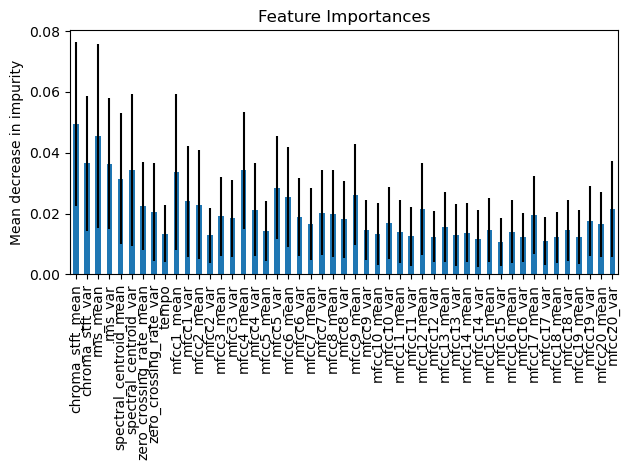

In [11]:
# ====================== Perform Feature Importance =========================

importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


<Axes: xlabel='chroma_stft_mean', ylabel='rms_mean'>

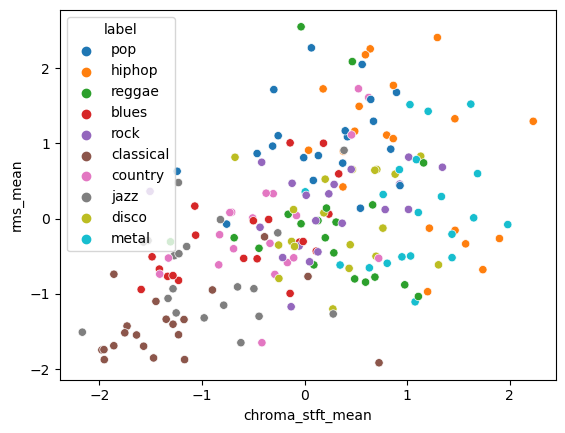

In [12]:
# ===================== Scatterplot of a Sampling of Genres ==================

"""
Taking the 2 most important features from the feature importance test above, 
I generate a scatterplot showing the relationship between them.
"""

scatter_X = X_test[['chroma_stft_mean', 'rms_mean']]
scatter_y = y_test

sns.scatterplot(x=scatter_X.iloc[:,0], y=scatter_X.iloc[:,1], data=scatter_X, hue=scatter_y)

/Users/jbaca/Desktop/Class_Work/Summer 2023/Data Science With Python/Final Project/Baca_CS677_FinalProject/cs677_venv/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Decision Boundary')

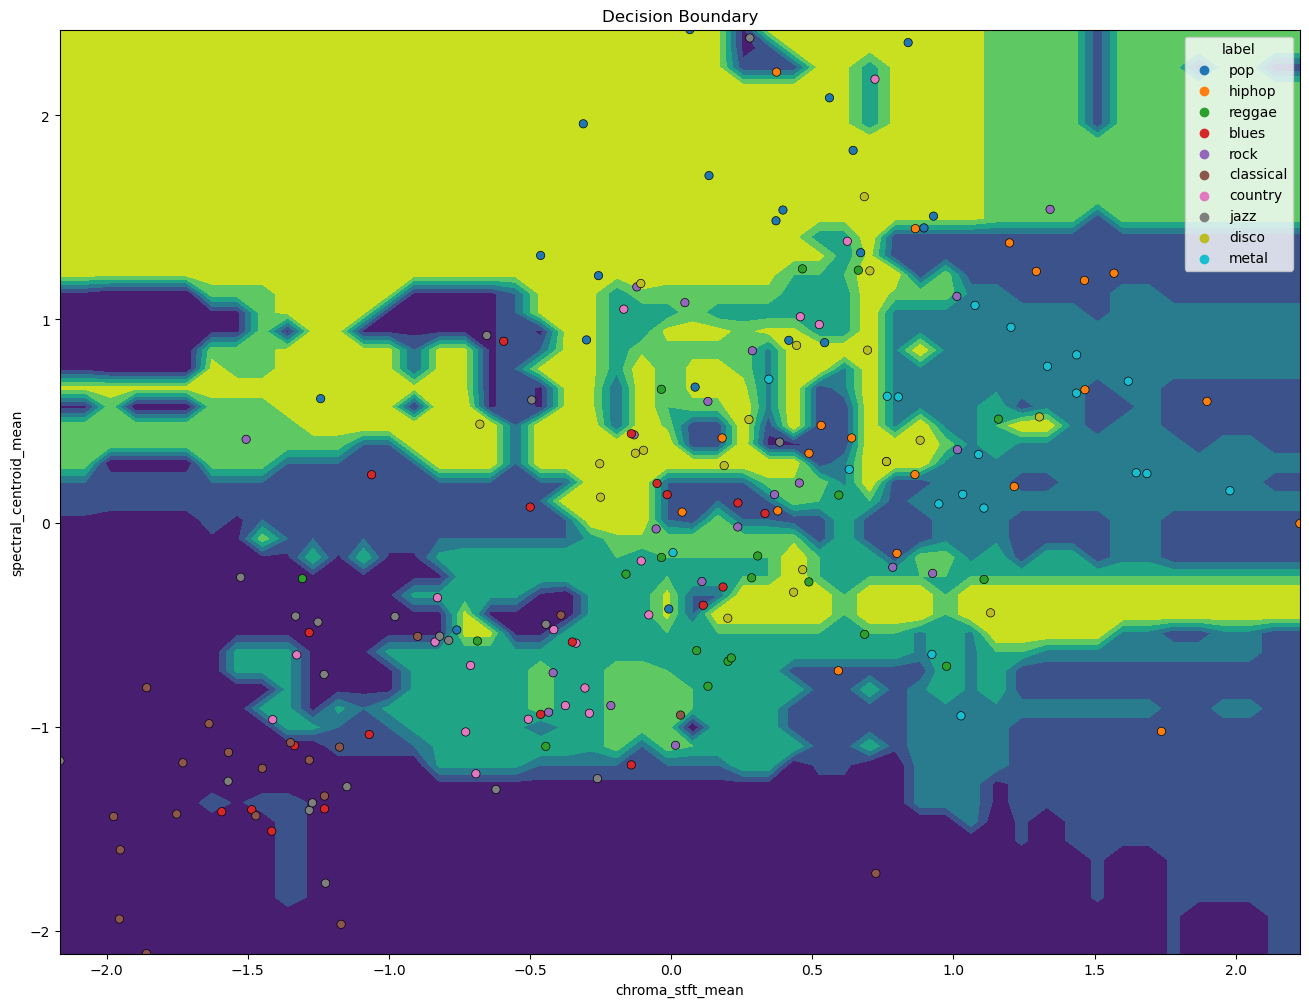

In [13]:
import seaborn as sns

# =============== Plot The Decision Boundary Between 2 Most Correlated Features ==============

"""
For the sake of experimentation, I attempted to plot a decision boundary similar to the ones
created in class for the Iris dataset. However, with 10 classes it proved to not be very helpful.
"""

dec_boundary = X_test[['chroma_stft_mean', 'spectral_centroid_mean']]
dec_boundary.columns = ['chroma_stft_mean', 'spectral_centroid_mean']

colormap_rf = RandomForestClassifier()
colormap_rf.fit(dec_boundary, y_test)

feature_1, feature_2 = np.meshgrid(
     np.linspace(dec_boundary.iloc[:, 0].min(), dec_boundary.iloc[:, 0].max()),
     np.linspace(dec_boundary.iloc[:, 1].min(), dec_boundary.iloc[:, 1].max())
 )
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
y_pred = np.reshape(pd.factorize(colormap_rf.predict(grid))[0], feature_1.shape)

codes, uniques = pd.factorize(y_pred[0])

plt.figure(figsize=(16,12))
plt.contourf(feature_1, feature_2, y_pred)

# Scatterplot of training data
sns.scatterplot(
    x=dec_boundary.iloc[:, 0],
    y=dec_boundary.iloc[:, 1],
    hue=y_test,
    alpha=1.0,
    edgecolor="black",
)
plt.xlim(dec_boundary.iloc[:, 0].min(), dec_boundary.iloc[:, 0].max())
plt.ylim(dec_boundary.iloc[:, 1].min(), dec_boundary.iloc[:, 1].max())
plt.title("Decision Boundary")

[0.3414287796616554, 0.26354215368628503, 0.3438120503723621, 0.41564298257231713, 0.45431886047124864, 0.2966431502997875, 0.4792349606752396, 0.39763181179761886, 0.40824693351984026, 0.38631530076265336]
[0.13606707137078045, 0.04291990640573198, 0.12598752725869414, 0.13629600394517183, 0.1783437218144536, 0.08664808638393875, 0.1534775453433394, 0.19973390005528927, 0.12250284336507317, 0.12732043493539094]
[1727.5846611350414, 1353.8788368750404, 1896.2106216062548, 2619.8522292888406, 2524.5185226038043, 1792.3600970427856, 2602.1812035513926, 3073.5495378554356, 2185.0167553419333, 2242.6565118077156]
[-164.5942618393898, -320.0519675445557, -145.02541305541993, -93.71507290363311, -103.00678637981414, -214.5514478302002, -63.058390024006364, -67.85120398521423, -162.5517915725708, -110.32353582143783]


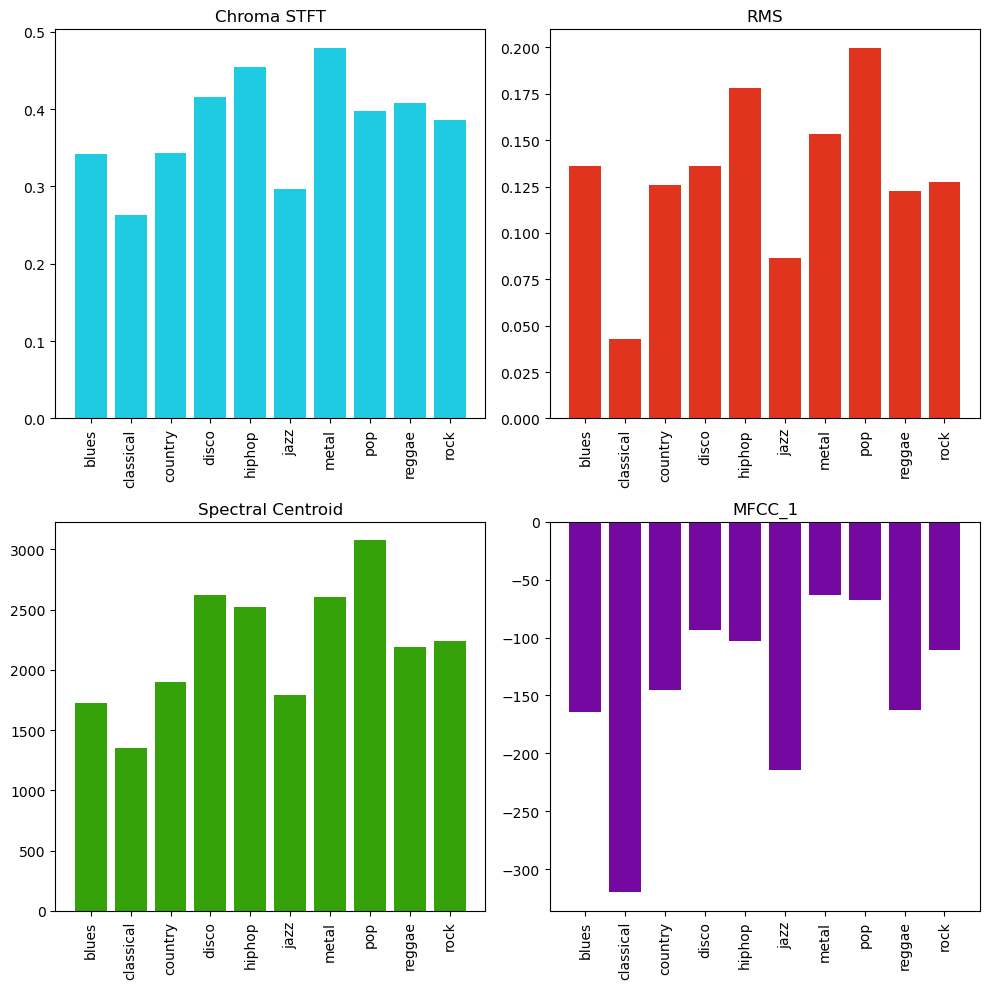

In [14]:
# =============== Plotting Most Prominent Features ===============

"""""
Here we plot the means of the 4 most significant features by genre to show the relationship 
of each features between different genres. For example, we can see that Classical and Jazz
both have relatively low values for the Spectral Centroid, while Pop has the highest.
"""""

#Chroma STFT 
chromas = []
genres = df['label'].unique()

for x in genres:
    chromas.append(np.mean(df['chroma_stft_mean'].loc[df['label']==x]))
    
print(chromas)

fig, ax = plt.subplots(2,2)

ax[0,0].bar(genres, chromas, color='#1ECBE1')
tick_positions = range(len(genres))
ax[0,0].set_xticks(tick_positions)
ax[0,0].set_xticklabels(genres, rotation='vertical')
ax[0,0].set_title("Chroma STFT")

#RMS 
rms = []
for x in genres:
    rms.append(np.mean(df['rms_mean'].loc[df['label']==x]))
    
print(rms)

ax[0,1].bar(genres, rms, color='#E1341E')
ax[0,1].set_title("RMS")
ax[0,1].set_xticks(tick_positions)
ax[0,1].set_xticklabels(genres, rotation='vertical')


#Spectral Centroid
sc = []
for x in genres:
    sc.append(np.mean(df['spectral_centroid_mean'].loc[df['label']==x]))
    
print(sc)

ax[1,0].bar(genres, sc, color='#34a108')
ax[1,0].set_title("Spectral Centroid")
ax[1,0].set_xticks(tick_positions)
ax[1,0].set_xticklabels(genres, rotation='vertical')


#MFCC_1
mfcc1 = []
for x in genres:
    mfcc1.append(np.mean(df['mfcc1_mean'].loc[df['label']==x]))
    
print(mfcc1)

ax[1,1].bar(genres, mfcc1, color='#7508A1')
ax[1,1].set_title("MFCC_1")
ax[1,1].set_xticks(tick_positions)
ax[1,1].set_xticklabels(genres, rotation='vertical')

# plt.figure(figsize=(20,12))
fig.set_size_inches(10, 10)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [15]:
#====================== Extracting Features Using Librosa ==================

"""
In order to classify new audio files not included in the original dataset, we need to be able to 
extract the features. The code below uses the Librosa Python library to do so.
"""

import librosa

# Test Audio Files
filenames = ['Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy.ogg', #Classical
             'Claire_De_Lune.wav',                                                #Classical
             'Smells_Like_Teen_Spirit.wav',                                       #Rock
             'Stella_By_Starlight.wav',                                           #Jazz
             'Umbrella.wav',                                                      #Pop
             'Bulls_On_Parade.wav',                                               #Rock
             'Confirmation.wav',                                                  #Jazz
             'Jamming.wav',                                                       #Reggae
             'Purple_Haze.wav',                                                   #Rock
             'Toxic.wav']                                                         #Pop                         

def extract_features(filename):
    feature_matrix = pd.DataFrame(columns=X.columns)
    
    y, sr = librosa.load(filename)
    
    #Chroma Stft
    feature_matrix['chroma_stft_mean'] = [np.mean(librosa.feature.chroma_stft(y=y, sr=sr))]
    feature_matrix['chroma_stft_var'] = [np.var(librosa.feature.chroma_stft(y=y, sr=sr))]
    
    #RMS
    feature_matrix['rms_mean'] = [np.mean(librosa.feature.rms(y=y))]
    feature_matrix['rms_var'] = [np.var(librosa.feature.rms(y=y))]
    
    #Spectral Centroid
    feature_matrix['spectral_centroid_mean'] = [np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))]
    feature_matrix['spectral_centroid_var'] = [np.var(librosa.feature.spectral_centroid(y=y, sr=sr))]
    
    # #Spectral Bandwidth
    # feature_matrix['spectral_bandwidth_mean'] = [np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))]
    # feature_matrix['spectral_bandwidth_var'] = [np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))]
    
    # #Rolloff
    # feature_matrix['rolloff_mean'] = [np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))]
    # feature_matrix['rolloff_var'] = [np.var(librosa.feature.spectral_rolloff(y=y, sr=sr))]
    
    #Zero Crossing Rate
    feature_matrix['zero_crossing_rate_mean'] = [np.mean(librosa.feature.zero_crossing_rate(y=y,frame_length=2048, hop_length=512, center=True))]
    feature_matrix['zero_crossing_rate_var'] = [np.var(librosa.feature.zero_crossing_rate(y=y,frame_length=2048, hop_length=512, center=True))]

    #Tempo
    feature_matrix['tempo'] = [librosa.feature.tempo(y=y, sr=sr, onset_envelope=None, tg=None, hop_length=512, start_bpm=120, std_bpm=1.0, ac_size=8.0, max_tempo=320.0, prior=None)]
    
    #mfcc
    mfccs = librosa.feature.mfcc(y=y, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0)
    # print("mfccs", mfccs)
    mfcc_means = []
    mfcc_vars = []
    
    j = 1
        
    for i in mfccs:
        mfcc_means.append([np.mean(i)])
        mfcc_vars.append([np.mean(i)])
        feature_matrix[f'mfcc{j}_mean'] = np.mean(i)
        feature_matrix[f'mfcc{j}_var'] = np.var(i)
        j+=1
        
    #scale data and convert back to dataframe    
    
    feature_matrix = scaler.transform(feature_matrix)
    feature_matrix = pd.DataFrame(feature_matrix, columns=X.columns)
        
    return feature_matrix

# =============== Running my own test on new audio files ===============
for file in filenames:
    features = extract_features("Test_Audio_Files/"+file)
    print(rf.predict(features))

['classical']
['classical']
['pop']
['pop']
['pop']
['disco']
['jazz']
['reggae']
['rock']
['hiphop']
